# House Prices Prediction

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

http://jse.amstat.org/v19n3/decock.pdf

In [358]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import ensemble, tree, linear_model,cross_validation
from sklearn.model_selection import GridSearchCV
import xgboost as xgboost
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


In [288]:
#Getting Data

train_predictors = pd.read_csv('train.csv')
test_predictors = pd.read_csv('test.csv')
print("train : " + str(train_predictors.shape))
print("test : " + str(test_predictors.shape))

train : (1460, 81)
test : (1459, 80)


In [289]:
#Get Correlations

correlations = train_predictors.corr()
correlations = correlations["SalePrice"].sort_values(ascending=False)
correlations

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [290]:
#Drop Target variable from Train Data set
train_target = train_predictors['SalePrice']
#train_predictors = train.drop(['SalePrice'],axis=1)

In [291]:
train_ID = train_predictors['Id']
test_ID = test_predictors['Id']

In [292]:
# Drop Id column from train and test data sets
train_predictors.drop("Id", axis = 1, inplace = True)
test_predictors.drop("Id", axis = 1, inplace = True)

In [293]:
train_predictors.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


**Pre Processing**

As Indicated in http://jse.amstat.org/v19n3/decock.pdf we will identify outliers and and remove them

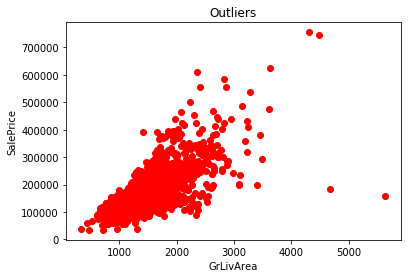

In [294]:
plt.scatter(train_predictors.GrLivArea, train_predictors.SalePrice, c= 'red')
plt.title("Outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()



 The author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset in http://jse.amstat.org/v19n3/decock.pdf

In [295]:
train_predictors = train_predictors[train_predictors.GrLivArea < 4000]

Check for skewness in Target Variable

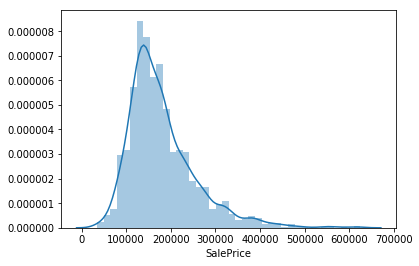

In [296]:
train_target = train_predictors['SalePrice']
sns.distplot(train_target)

It is Right skewed

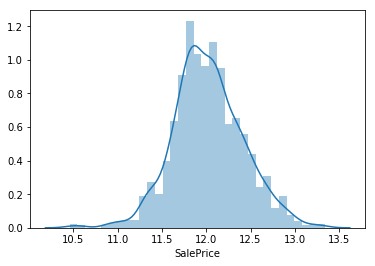

In [297]:
sns.distplot(np.log(train_target))
#Applying log will reduce the effect of Cheap and expensive houses on the models

In [298]:
train_target_final = np.log(train_target)

Dealing with Missing Values

In [299]:
train_predictors_missing = pd.isna(train_predictors).sum()
test_missing = pd.isna(test_predictors).sum()

missing = pd.concat([train_predictors_missing, test_missing], axis=1, keys=["Train", "Test"])


missing_values = missing[missing.sum(axis=1) > 0]  #Missing Values
missing_values

,Train,Test
Alley,1365,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


Missing values which has some meaning

For example If PoolQC variable is missing that indicates that there is no Pool in th House, We should not remove these types of variables even though they are missing

In [300]:
#There are some features which are categorical and whose missing values are meaningful these we can know by looking Description of Data

meaningful_missing = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                    "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", 
                    "GarageCond", "Fence","PoolQC", "MiscFeature"]

In [301]:
for i in meaningful_missing:
    train_predictors[i].fillna("None", inplace=True)
    test_predictors[i].fillna("None", inplace=True)

In [302]:
train_predictors.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,1,2008,WD,Normal,118000


Missing Values with no explaination for those Missing values

In [303]:
train_missing1 = pd.isna(train_predictors).sum()
test_missing1 = pd.isna(test_predictors).sum()

missing1 = pd.concat([train_missing1, test_missing1], axis=1, keys=["Train", "Test"])


missing1_values = missing1[missing1.sum(axis=1) > 0]  #Missing Values
missing1_values

,Train,Test
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtUnfSF,0,1.0
Electrical,1,0.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
Functional,0,2.0
GarageArea,0,1.0


In [304]:
#LotFrontage which is Numeric value has many missing values so we remove it
train_predictors.drop("LotFrontage", axis=1, inplace=True)
test_predictors.drop("LotFrontage", axis=1, inplace=True)

In [305]:
train_predictors.columns

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [306]:
test_predictors.shape

(1459, 78)

In [307]:
train_predictors.shape

(1456, 79)

Separate Numeric and Categorical features in the train and test data sets

In [308]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [309]:
numeric_features_train.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [310]:
numeric_features_test.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [311]:
# There are some Numerical features in the data set which are actually categorical, 
#They are MSSubClass and MoSold (Month sold)
#we need to convert them into categorical
train_predictors = train_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

test_predictors = test_predictors.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [312]:
#Drop Target variable from Train Data set
train_predictors = train_predictors.drop(['SalePrice'],axis=1)

In [313]:
numeric_features_train = train_predictors.select_dtypes(include=[np.number])

numeric_features_test = test_predictors.select_dtypes(include=[np.number])

In [314]:
categorical_features_train = train_predictors.select_dtypes(include=[object])

categorical_features_test = test_predictors.select_dtypes(include=[object])

In [315]:
numeric_features_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold'],
      dtype='object')

In [316]:
numeric_features_train.fillna(numeric_features_train.mean(),inplace=True)
numeric_features_test.fillna(numeric_features_test.mean(),inplace=True)

In [317]:
numeric_features_train.shape

(1456, 33)

In [318]:
numeric_features_test.shape

(1459, 33)

In [319]:
categorical_features_train.fillna(categorical_features_train.mode(), inplace = True)
categorical_features_test.fillna(categorical_features_test.mode(), inplace = True)

In [320]:
categorical_features_train.shape

(1456, 45)

In [321]:
categorical_features_test.shape

(1459, 45)

In [322]:
#Combining Categorical features of both train and test sets for Encoding
categorical_features_traintest = pd.concat([categorical_features_train , categorical_features_test])

In [323]:
ntrain = categorical_features_train.shape[0]
ntrain

1456

In [324]:
categorical_features_traintest.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

Encoding Categorical features

In [325]:
#BackwardDifference Encoder
import category_encoders as ce
encoder = ce.BackwardDifferenceEncoder(cols=['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'])
categorical_encoded = encoder.fit_transform(categorical_features_traintest)

categorical_encoded.head()

,intercept,MSSubClass_0,MSSubClass_1,MSSubClass_2,MSSubClass_3,MSSubClass_4,MSSubClass_5,MSSubClass_6,MSSubClass_7,MSSubClass_8,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
1,1,0.0625,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
2,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
3,1,0.0625,0.125,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,0.166667,-0.666667,-0.5,-0.333333,-0.166667
4,1,-0.9375,-0.875,-0.8125,-0.75,-0.6875,-0.625,-0.5625,-0.5,-0.4375,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667


In [326]:
#Separating Categorical features of Train and test data sets after encoding
categorical_train_encoded = categorical_encoded[:ntrain]
categorical_test_encoded = categorical_encoded[ntrain:]

In [327]:
final_train = pd.concat([numeric_features_train, categorical_train_encoded],axis=1)
final_test = pd.concat([numeric_features_test, categorical_test_encoded],axis=1)

In [328]:
final_train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4
0,8450,7,5,2003,2003,196.0,706,0,150,856,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
1,9600,6,8,1976,1976,0.0,978,0,284,1262,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
2,11250,7,5,2001,2002,162.0,486,0,434,920,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667
3,9550,7,5,1915,1970,0.0,216,0,540,756,...,-0.5,-0.4,-0.3,-0.2,-0.1,0.166667,-0.666667,-0.5,-0.333333,-0.166667
4,14260,8,5,2000,2000,350.0,655,0,490,1145,...,-0.5,-0.4,-0.3,-0.2,-0.1,-0.833333,-0.666667,-0.5,-0.333333,-0.166667


In [329]:
final_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7', 'SaleType_8',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=291)

In [330]:
final_test.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_4', 'SaleType_5', 'SaleType_6', 'SaleType_7', 'SaleType_8',
       'SaleCondition_0', 'SaleCondition_1', 'SaleCondition_2',
       'SaleCondition_3', 'SaleCondition_4'],
      dtype='object', length=291)

# Feature Engineering

In [331]:
#Adding new features to train and test data
# Overall quality of the house
# Total number of bathrooms
final_train["TotalBath"] = final_train["BsmtFullBath"] + (0.5 * final_train["BsmtHalfBath"]) + \
final_train["FullBath"] + (0.5 * final_train["HalfBath"])

final_test["TotalBath"] = final_test["BsmtFullBath"] + (0.5 * final_test["BsmtHalfBath"]) + \
final_test["FullBath"] + (0.5 * final_test["HalfBath"])

# Total SF for house (incl. basement)
final_train["AllSF"] = final_train["GrLivArea"] + final_train["TotalBsmtSF"]

final_test["AllSF"] = final_test["GrLivArea"] + final_test["TotalBsmtSF"]

# Total SF for 1st + 2nd floors
final_train["AllFlrsSF"] = final_train["1stFlrSF"] + final_train["2ndFlrSF"]

final_test["AllFlrsSF"] = final_test["1stFlrSF"] + final_test["2ndFlrSF"]

# Total SF for porch
final_train["AllPorchSF"] = final_train["OpenPorchSF"] + final_train["EnclosedPorch"] + \
final_train["3SsnPorch"] + final_train["ScreenPorch"]

final_test["AllPorchSF"] = final_test["OpenPorchSF"] + final_test["EnclosedPorch"] + \
final_test["3SsnPorch"] + final_test["ScreenPorch"]

In [332]:
final_train.shape

(1456, 295)

In [333]:
final_test.shape

(1459, 295)

# Modeling

In [334]:
# Partition the dataset in train + validation sets
from sklearn.model_selection import train_test_split #to create validation data set
X_train, X_test, y_train, y_test = train_test_split(final_train, train_target_final, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 295)
X_test : (437, 295)
y_train : (1019,)
y_test : (437,)


 Linear Regression without regularization

In [335]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [336]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [337]:
mse_train = np.mean((y_train_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lm.score(X_test,y_test))

MSE on Training set :  0.007327081149123891
MSE on Test set :  0.016879783213044276
0.8920723516191187


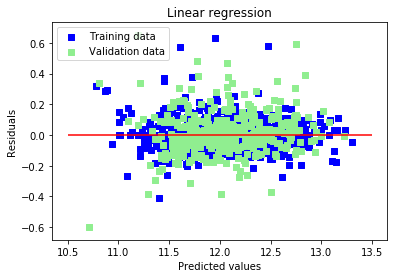

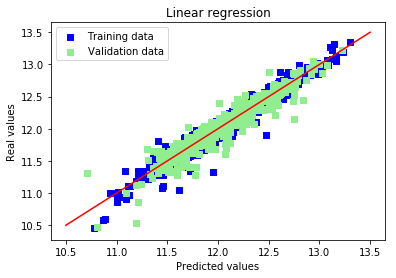

In [338]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Linear Regression with Ridge regularization (L2 Penalty)

In [339]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 30, 40, 50, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 20.0


In [340]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=[1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 30, 40, 50, 60],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [341]:
y_train_ridge_pred = ridge.predict(X_train)
y_test_ridge_pred = ridge.predict(X_test)

In [342]:
mse_train = np.mean((y_train_ridge_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_ridge_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(ridge.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  0.009933557749263747
MSE on Test set :  0.012115361927271452
0.9225355855824497


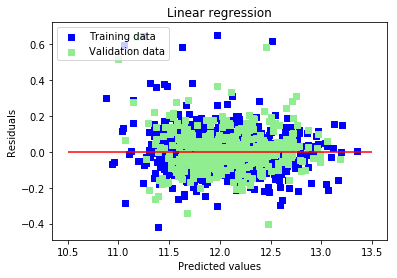

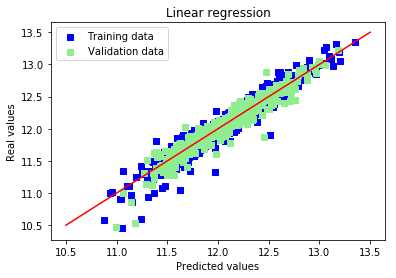

In [343]:
# Plot residuals
plt.scatter(y_train_ridge_pred, y_train_ridge_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test_ridge_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_ridge_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ridge_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()



Ridge picked 284 features and eliminated the other 11 features


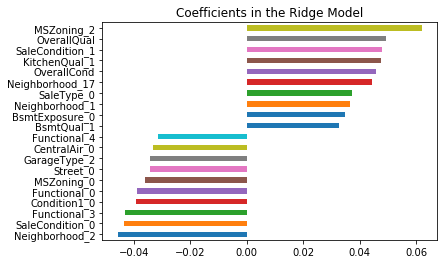

In [344]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Linear Regression with Lasso regularization (L1 Penalty)

In [345]:
from sklearn.linear_model import LassoCV


lasso = LassoCV(alphas = [0.0001, 0.0002,0.0004, 0.0006, 0.001, 0.002,0.004, 0.006, 0.01, 0.02,0.04, 0.06, 0.1, 
                          0.2,0.4, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0006


In [346]:
lasso.fit(X_train, y_train)

LassoCV(alphas=[0.0001, 0.0002, 0.0004, 0.0006, 0.001, 0.002, 0.004, 0.006, 0.01, 0.02, 0.04, 0.06, 0.1, 0.2, 0.4, 0.6, 1],
    copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [347]:
y_train_lasso_pred = lasso.predict(X_train)
y_test_lasso_pred = lasso.predict(X_test)

In [348]:
mse_train = np.mean((y_train_lasso_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_lasso_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(lasso.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  0.010192486873506374
MSE on Test set :  0.012161811295403753
0.9222385929606829


Lasso picked 110 features and eliminated the other 185 features


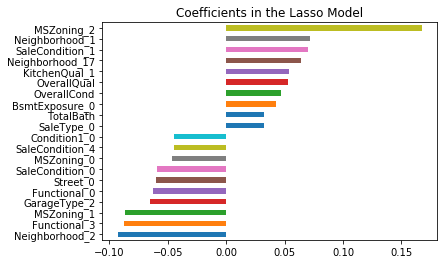

In [349]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

XGBoost

In [354]:
from xgboost import XGBRegressor

In [355]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}

In [359]:
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_child_weight': [4, 5], 'gamma': [0.3, 0.4, 0.5], 'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [360]:
y_train_xgb_pred = grid.predict(X_train)
y_test_xgb_pred = grid.predict(X_test)

In [361]:
mse_train = np.mean((y_train_xgb_pred - y_train)**2)
print("MSE on Training set : ", mse_train )


mse_test = np.mean((y_test_xgb_pred - y_test)**2)

print("MSE on Test set : ", mse_test )

print(grid.score(X_test,y_test))

#MSE on the test set slightly reduced

MSE on Training set :  0.013516549904614492
MSE on Test set :  0.015096515308875076
0.9034743885351706
